In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./data/BTCUSDT_1h.csv")

In [3]:
df = df.sort_values('close_time')
features = ['open', 'high', 'low', 'close', 'volume']
data = df[features].values

In [4]:
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# Create sequences
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

SEQ_LEN = 24  
X = create_sequences(data_scaled, SEQ_LEN)

In [6]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

# Split into training and validation datasets
X_train, X_val = train_test_split(X_tensor, test_size=0.1, shuffle=False)

# DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=32, shuffle=False)

In [7]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.seq_len = seq_len
        
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)
        
        self.fc = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Encoder
        _, (hidden, _) = self.encoder(x)

        # Repeat the hidden state SEQ_LEN times
        decoder_input = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)  # [batch_size, seq_len, hidden_dim]

        # Decoder
        decoded, _ = self.decoder(decoder_input)

        # Project back to original feature space
        decoded = self.fc(decoded)
        return decoded

In [8]:
# Initialize model
input_dim = X.shape[2]  # Number of features
hidden_dim = 124  # Size of the LSTM hidden layer

model = LSTM_Autoencoder(input_dim, hidden_dim, SEQ_LEN)

In [9]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007729558899578971)



In [10]:
# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)



C:\Users\josiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# Function to compute RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

# Function to compute MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

In [12]:
# Training loop
num_epochs = 100

train_losses, val_losses, lrs, rmse_values, mae_values = [], [], [], [], []


In [13]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_rmse = 0.0
    epoch_mae = 0.0

    lr = optimizer.param_groups[0]['lr']

    for batch in train_loader:
        X_batch = batch[0]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(X_batch)
        
        # Compute loss
        loss = criterion(output, X_batch)
        

        epoch_rmse += rmse(X_batch, output).item()
        epoch_mae += mae(X_batch, output).item()
        

        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_rmse = epoch_rmse / len(train_loader)
    avg_mae = epoch_mae / len(train_loader)
    
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_rmse = 0.0
    epoch_val_mae = 0.0


    with torch.no_grad():
        for batch in val_loader:
            X_batch = batch[0]
            output = model(X_batch)

            loss = criterion(output, X_batch)
            epoch_val_loss += loss.item()
            
            # Compute validation RMSE and MAE
            epoch_val_rmse += rmse(X_batch, output).item()
            epoch_val_mae += mae(X_batch, output).item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_rmse = epoch_val_rmse / len(val_loader)
    avg_val_mae = epoch_val_mae / len(val_loader)

    # Calculate the average loss
    avg_train_loss = epoch_train_loss / len(train_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    lrs.append(lr)
    rmse_values.append(avg_val_rmse)
    mae_values.append(avg_val_mae)
    
    # Step the learning rate scheduler
    lr_scheduler.step(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'\tRMSE (Train): {avg_rmse:.4f}, RMSE (Val): {avg_val_rmse:.4f}')
    print(f'\tMAE (Train): {avg_mae:.4f}, MAE (Val): {avg_val_mae:.4f}')    
    

Epoch [1/100], Train Loss: 0.0007, Val Loss: 0.0005
	RMSE (Train): 0.0222, RMSE (Val): 0.0216
	MAE (Train): 0.0120, MAE (Val): 0.0165
Epoch [2/100], Train Loss: 0.0003, Val Loss: 0.0008
	RMSE (Train): 0.0179, RMSE (Val): 0.0269
	MAE (Train): 0.0089, MAE (Val): 0.0232
Epoch [3/100], Train Loss: 0.0003, Val Loss: 0.0004
	RMSE (Train): 0.0173, RMSE (Val): 0.0190
	MAE (Train): 0.0083, MAE (Val): 0.0145
Epoch [4/100], Train Loss: 0.0003, Val Loss: 0.0004
	RMSE (Train): 0.0166, RMSE (Val): 0.0185
	MAE (Train): 0.0076, MAE (Val): 0.0139
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0003
	RMSE (Train): 0.0164, RMSE (Val): 0.0167
	MAE (Train): 0.0074, MAE (Val): 0.0123
Epoch [6/100], Train Loss: 0.0003, Val Loss: 0.0005
	RMSE (Train): 0.0160, RMSE (Val): 0.0202
	MAE (Train): 0.0068, MAE (Val): 0.0150
Epoch [7/100], Train Loss: 0.0003, Val Loss: 0.0015
	RMSE (Train): 0.0161, RMSE (Val): 0.0382
	MAE (Train): 0.0069, MAE (Val): 0.0356
Epoch [8/100], Train Loss: 0.0003, Val Loss: 0.0005
	RMSE (Tra

In [14]:
# Compute reconstruction error on validation set
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for batch in val_loader:
        X_batch = batch[0]
        output = model(X_batch)
        loss = torch.mean((output - X_batch) ** 2, dim=(1,2))  # MSE for each sequence
        reconstruction_errors.extend(loss.numpy())

num_sequences = len(X)

# Get number of validation samples
num_val = len(X_val)

# Find the starting index in the original DataFrame
val_start_idx = num_sequences - num_val

# Align the original dataframe accordingly
df_plot = df.iloc[SEQ_LEN + val_start_idx:].copy()

# Add reconstruction errors
df_plot['reconstruction_error'] = reconstruction_errors

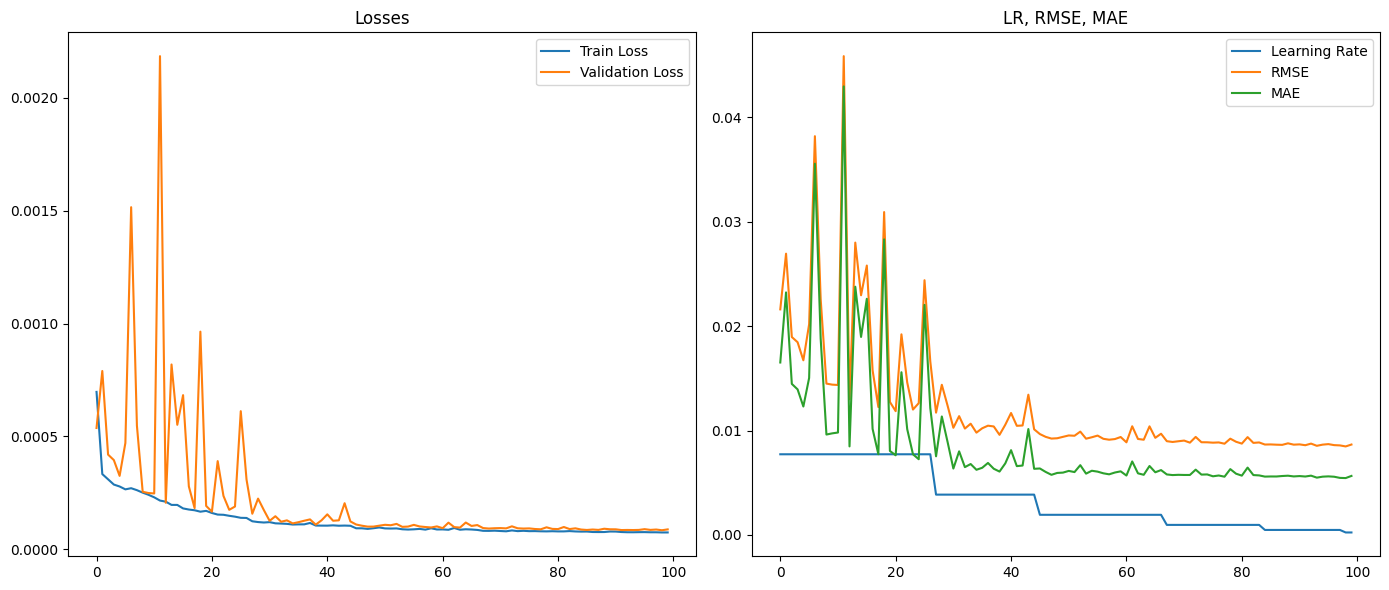

In [15]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.plot(rmse_values, label='RMSE')
plt.plot(mae_values, label='MAE')
plt.legend()
plt.title('LR, RMSE, MAE')
plt.tight_layout()
plt.show()

In [16]:
model.eval()
reconstructions = []
errors = []

with torch.no_grad():
    for batch in DataLoader(TensorDataset(X_tensor), batch_size=32, shuffle=False):
        X_batch = batch[0]
        output = model(X_batch)
        reconstructions.append(output)
        
        # Per-sequence error (MSE)
        batch_errors = torch.mean((output - X_batch) ** 2, dim=(1, 2))  # mean over seq_len and features
        errors.append(batch_errors)

reconstructions = torch.cat(reconstructions)
errors = torch.cat(errors).numpy()  # Shape: [num_sequences]


In [17]:
threshold = np.percentile(errors, 95)  # Top 5% as anomalies


In [18]:
anomalies = errors > threshold


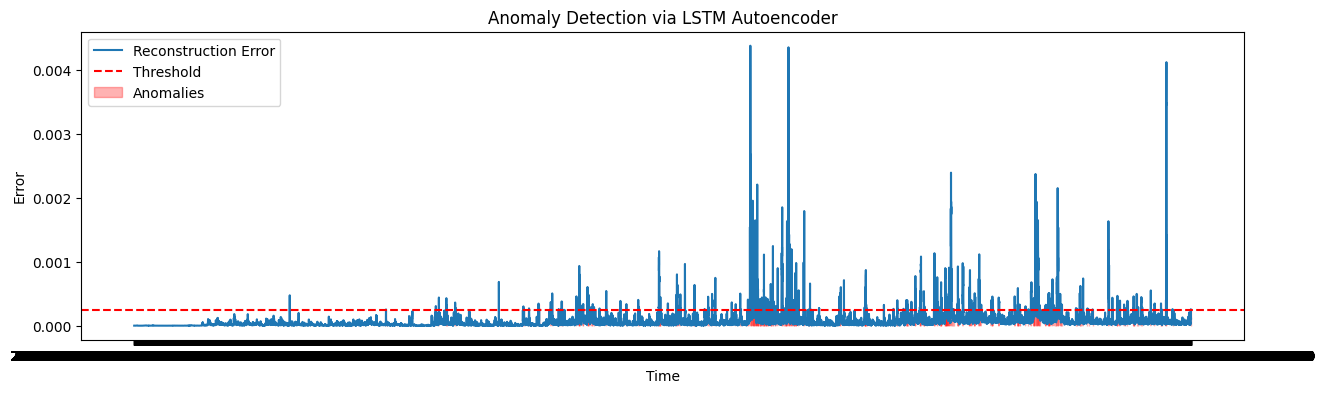

In [19]:

timestamps = df['close_time'].values[SEQ_LEN:]  # align with sequences

plt.figure(figsize=(15, 4))
plt.plot(timestamps, errors, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.fill_between(timestamps, 0, errors, where=anomalies, color='red', alpha=0.3, label="Anomalies")
plt.legend()
plt.title("Anomaly Detection via LSTM Autoencoder")
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()


In [20]:
# Number of anomalies
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 1922


In [21]:
close_index = df.columns.get_loc("close") - 1  # adjust for SEQ_LEN offset

recon_close = reconstructions[:, -1, close_index].numpy()
actual_close = X_tensor[:, -1, close_index].numpy()

# Save anomaly info
base_index = SEQ_LEN  # offset for aligning with original df
anomaly_df = df.iloc[base_index:][anomalies].copy()  # only anomalies

anomaly_df['predicted_close'] = recon_close[anomalies]
anomaly_df['actual_close'] = actual_close[anomalies]
anomaly_df['abs_error'] = np.abs(anomaly_df['actual_close'] - anomaly_df['predicted_close'])

anomaly_df.to_csv("results/lstm_autoencoder_anomalies.csv", index=False)
print("Anomalies saved to lstm_autoencoder_anomalies.csv")

Anomalies saved to lstm_autoencoder_anomalies.csv


In [22]:
df2 = pd.read_csv("results/lstm_autoencoder_anomalies.csv")

In [23]:
df2.head()

,open,high,low,close,volume,close_time,quote,takers_buy_base,takers_buy_quote,predicted_close,actual_close,abs_error
0,7685.55,7780.00,7569.83,7686.93,7501.318100,2018-04-12 07:59:59.999000-05:00,5.754492e+07,3534.788744,2.712034e+07,0.056360,0.062742,0.006382
1,7686.93,7739.80,7627.00,7683.18,3525.785109,2018-04-12 08:59:59.999000-05:00,2.710017e+07,1662.304104,1.278317e+07,0.062941,0.072414,0.009473
2,6444.60,6476.46,6422.00,6442.00,2013.750542,2018-09-05 23:59:59.999000-05:00,1.297394e+07,1133.661530,7.304693e+06,0.057252,0.054758,0.002494
3,4455.02,4596.77,4400.00,4558.86,6116.032906,2018-11-20 18:59:59.999000-05:00,2.741123e+07,3841.973483,1.722002e+07,0.025080,0.024929,0.000151
4,4559.91,4590.00,4459.62,4484.82,3500.741434,2018-11-20 19:59:59.999000-05:00,1.583441e+07,1746.783529,7.908437e+06,0.023701,0.024119,0.000417
